## Cruzamento e análise de dados

Neste caderno faremos o cruzamento das seguintes fontes de dados:

1. API TransfereGov
2. Deputados
3. Senadores

Após cruzar os dados, faremos uma análise exploratória simples.

In [1]:
%pip install -q fastparquet plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import plotly.graph_objects as go

### Carregar os dados

Vamos carregar os dados que foram salvos na pasta `dados` pelo caderno `1 Baixar os dados.ipynb`.

In [3]:
df_transferencias = pd.read_parquet("dados/transferencias-especiais.parquet")

In [4]:
df_deputados = pd.read_parquet("dados/deputados.parquet")

In [5]:
df_senadores = pd.read_parquet("dados/senadores.parquet")

### Escopo

Estamos trabalhando com os dados dos deputados e senadores que exercem o mandato no
momento atual.

Nos dados das emendas de 2024, podem haver emendas de parlamentares que não possuem mais
mandatos (ex.: licenciou-se para tomar posse como ministro ou candidatar-se a prefeito,
faleceu, reunciou, foi cassado, etc.). Esses não estão presentes nas consultas de dados
da Câmara e do Senado, por isso as suas emendas não aparecerão quando cruzarmos os dados
desta forma.

In [6]:
# parlamentares com emendas, mas nas situações acima descritas - não vão aparecer
(
    set(df_transferencias.nome.unique())
    - set(df_deputados.nome.unique())
    - set(df_senadores.nome.unique())
)

{'Aj Albuquerque',
 'Amália Barros',
 'André Fernandes',
 'Coronel Telhada',
 'Dep. Josivaldo JP',
 'Dep. Roseana Sarney',
 'Dr. Allan Garcês',
 'Evair Vieira De Melo',
 'Fabio Garcia',
 'Geraldo Mendes',
 'Júnior Mano',
 'Márcio Correa',
 'Paulo Marinho JR',
 'Prof. Paulo Fernando',
 'Rogério Marinho',
 'Rosângela Moro',
 'Silvio Antonio'}

### Cruzamento

In [7]:
# Merge com df_deputados
df_emendas = df_transferencias.merge(
    df_deputados,
    on='nome',
    how='left',
    suffixes=('', '_deputado')
)
df_emendas['cargo']=None
df_emendas.loc[df_emendas['partido'].notna(),['cargo']]='deputado'

# Merge com df_senadores
df_emendas = df_emendas.merge(
    df_senadores,
    on='nome',
    how='left',
    suffixes=('', '_senador')
)
#
df_emendas.loc[df_emendas['partido_senador'].notna(),['cargo']]='senador'

# Verifica se as colunas existem antes de usar fillna
if 'partido_senador' in df_emendas.columns:
    df_emendas['partido'] = df_emendas['partido'].fillna(df_emendas['partido_senador'])
if 'uf_senador' in df_emendas.columns:
    df_emendas['uf'] = df_emendas['uf'].fillna(df_emendas['uf_senador'])

# Remover colunas extras se existirem
df_emendas = df_emendas.drop(
    columns=[col for col in ['partido_senador', 'uf_senador', 'partido_deputado', 'uf_deputado'] if col in df_emendas.columns]
)

# Resultado final
df_emendas


,id_plano_acao,codigo_plano_acao,ano_plano_acao,modalidade_plano_acao,situacao_plano_acao,cnpj_beneficiario_plano_acao,nome_beneficiario_plano_acao,uf_beneficiario_plano_acao,codigo_banco_plano_acao,codigo_situacao_dado_bancario_plano_acao,...,id_programa,id,uri,partido,uriPartido,uf,idLegislatura,urlFoto,email,cargo
0,69182,09032024-069182,2024,Especial,CIENTE,95990131000170,MUNICIPIO DE NOVA ITABERABA,SC,104,4.0,...,21,160604.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PT,https://dadosabertos.camara.leg.br/api/v2/part...,SC,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.pedrouczai@camara.leg.br,deputado
1,64478,09032024-064478,2024,Especial,CIENTE,41522186000126,MUNICIPIO DE PASSAGEM FRANCA DO PIAUI,PI,001,4.0,...,21,NaN,NaN,PSD,NaN,PI,NaN,NaN,NaN,senador
2,64487,09032024-064487,2024,Especial,CIENTE,01612590000176,MUNICIPIO DE MILTON BRANDAO,PI,104,4.0,...,21,NaN,NaN,PSD,NaN,PI,NaN,NaN,NaN,senador
3,72493,09032024-072493,2024,Especial,CIENTE,18114264000131,MUNICIPIO DE ESPERA FELIZ,MG,104,4.0,...,21,178895.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PSD,https://dadosabertos.camara.leg.br/api/v2/part...,MG,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.misaelvarella@camara.leg.br,deputado
4,73453,09032024-073453,2024,Especial,CIENTE,18114264000131,MUNICIPIO DE ESPERA FELIZ,MG,104,4.0,...,21,204524.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PP,https://dadosabertos.camara.leg.br/api/v2/part...,MG,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.pinheirinho@camara.leg.br,deputado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,65930,09032024-065930,2024,Especial,CIENTE,14197768000101,MUNICIPIO DE BREJOES,BA,104,4.0,...,21,178857.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PT,https://dadosabertos.camara.leg.br/api/v2/part...,BA,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.jorgesolla@camara.leg.br,deputado
10930,74317,09032024-074317,2024,Especial,CIENTE,75368928000122,MUNICIPIO DE MAMBORE,PR,104,4.0,...,21,220698.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PSD,https://dadosabertos.camara.leg.br/api/v2/part...,PR,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.betopreto@camara.leg.br,deputado
10931,73476,09032024-073476,2024,Especial,CIENTE,18094870000132,MUNICIPIO DE SENHORA DOS REMEDIOS,MG,001,4.0,...,21,204524.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PP,https://dadosabertos.camara.leg.br/api/v2/part...,MG,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.pinheirinho@camara.leg.br,deputado
10932,72488,09032024-072488,2024,Especial,CIENTE,46362927000172,MUNICIPIO DE BROTAS,SP,104,4.0,...,21,178985.0,https://dadosabertos.camara.leg.br/api/v2/depu...,PL,https://dadosabertos.camara.leg.br/api/v2/part...,SP,57.0,https://www.camara.leg.br/internet/deputado/ba...,dep.miguellombardi@camara.leg.br,deputado


### Análise exploratória

#### Quantidades de emendas

Quantas emendas há por deputados ou senadores?

In [8]:
df_emendas.cargo.value_counts()

cargo
deputado    8524
senador     2077
Name: count, dtype: int64

In [9]:
# na Câmara
df_emendas[df_emendas.cargo == "deputado"].partido.value_counts()

partido
PL               1620
PT               1080
PP                903
PSD               878
UNIÃO             875
MDB               710
REPUBLICANOS      698
PDT               366
PSDB              260
PODE              226
PSB               220
PRD               168
AVANTE            161
CIDADANIA         133
PCdoB              79
SOLIDARIEDADE      74
PV                 49
NOVO               15
REDE                7
PSOL                2
Name: count, dtype: int64

In [10]:
# no Senado
df_emendas[df_emendas.cargo == "senador"].partido.value_counts()

partido
MDB             495
PSD             352
PL              287
PP              272
UNIÃO           214
PODEMOS         136
REPUBLICANOS    126
PT               88
PSB              68
PSDB             20
PDT              19
Name: count, dtype: int64

#### Valores totais por parlamentar

In [11]:
df_emendas["valor_emenda"] = (
    df_emendas["valor_custeio_plano_acao"]
    + df_emendas["valor_investimento_plano_acao"]
)

In [12]:
colunas_agregacao = ["nome", "partido", "uf"]

In [13]:
df_emendas[colunas_agregacao+["cargo"]]

,nome,partido,uf,cargo
0,Pedro Uczai,PT,SC,deputado
1,Jussara Lima,PSD,PI,senador
2,Jussara Lima,PSD,PI,senador
3,Misael Varella,PSD,MG,deputado
4,Pinheirinho,PP,MG,deputado
...,...,...,...,...
10929,Jorge Solla,PT,BA,deputado
10930,Beto Preto,PSD,PR,deputado
10931,Pinheirinho,PP,MG,deputado
10932,Miguel Lombardi,PL,SP,deputado


##### Câmara

In [14]:
df_emendas_deputados = (
    df_emendas[df_emendas['cargo']=='deputado']
    .groupby(colunas_agregacao)
    .sum()
    ['valor_emenda']
    .sort_values(ascending=False)
    .head(15)
)
df_emendas_deputados


nome                      partido        uf
Yury do Paredão           MDB            CE    18935792.0
Robério Monteiro          PDT            CE    18935792.0
Roberto Duarte            REPUBLICANOS   AC    18935792.0
Marcos Aurélio Sampaio    PSD            PI    18935792.0
Pastor Sargento Isidório  AVANTE         BA    18935792.0
Paulinho da Força         SOLIDARIEDADE  SP    18935792.0
Pezenti                   MDB            SC    18935792.0
Pinheirinho               PP             MG    18935792.0
Duda Ramos                MDB            RR    18935792.0
Emanuel Pinheiro Neto     MDB            MT    18935792.0
José Nelto                UNIÃO          GO    18935792.0
Idilvan Alencar           PDT            CE    18935792.0
Fabio Schiochet           UNIÃO          SC    18935792.0
Meire Serafim             UNIÃO          AC    18935792.0
Luiz Fernando Faria       PSD            MG    18935792.0
Name: valor_emenda, dtype: float64

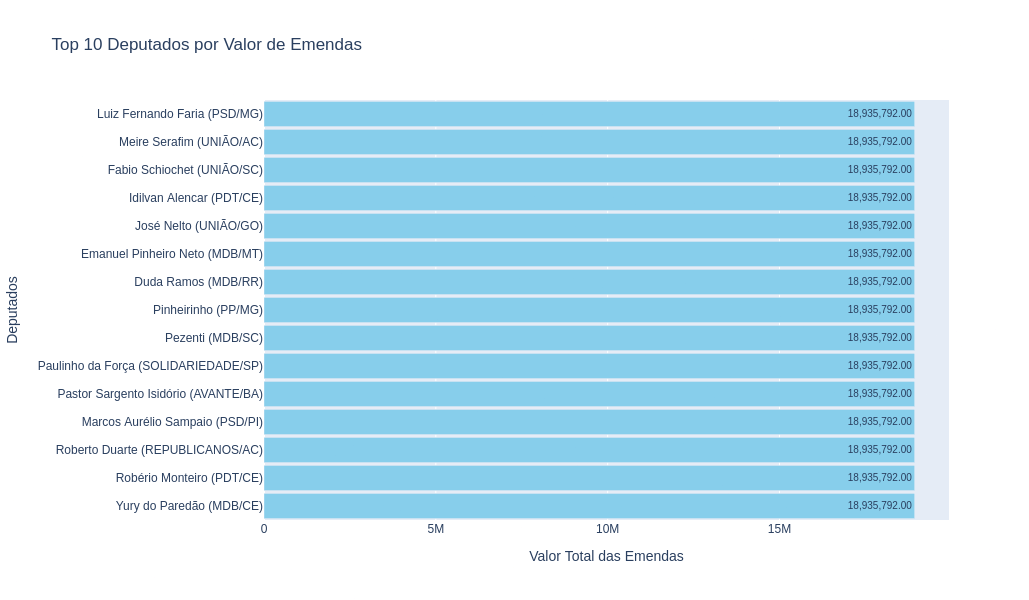

In [21]:
# Criando o gráfico de barras horizontais
fig = go.Figure(go.Bar(
    x=df_emendas_deputados.values,
    y=df_emendas_deputados.index.map(lambda x: f"{x[0]} ({x[1]}/{x[2]})"),
    orientation='h',
    marker_color='skyblue'
))

# Adicionando título e rótulos aos eixos
fig.update_layout(
    title='Top 10 Deputados por Valor de Emendas',
    xaxis_title='Valor Total das Emendas',
    yaxis_title='Deputados',
    font_size=12
)

# Adicionando os valores nas barras
for i, value in enumerate(df_emendas_deputados.values):
    fig.add_annotation(
        x=value,
        y=i,
        text=f'{value:,.2f}',
        textangle=0,
        font_size=10,
        showarrow=False,
        align='left',
        xanchor='right'
    )

# Ajustando o layout
fig.update_layout(
    height=600,
    width=800,
    bargap=0.1
)

# Exibindo o gráfico
fig.show()


##### Senado

In [16]:
df_emendas_senadores = (
    df_emendas[df_emendas['cargo']=='senador']
    .groupby(colunas_agregacao)
    .sum()
    ['valor_emenda']
    .sort_values(ascending=False)
    .head(10)
)
df_emendas_senadores

nome             partido  uf
Marcos Rogério   PL       RO    34817425.0
Jussara Lima     PSD      PI    34817425.0
Jayme Campos     UNIÃO    MT    34817425.0
Davi Alcolumbre  UNIÃO    AP    34815000.0
Otto Alencar     PSD      BA    34634850.0
Ciro Nogueira    PP       PI    34634850.0
Giordano         MDB      SP    34500000.0
Eliziane Gama    PSD      MA    34317425.0
Fernando Farias  MDB      AL    34317425.0
Angelo Coronel   PSD      BA    34134850.0
Name: valor_emenda, dtype: float64

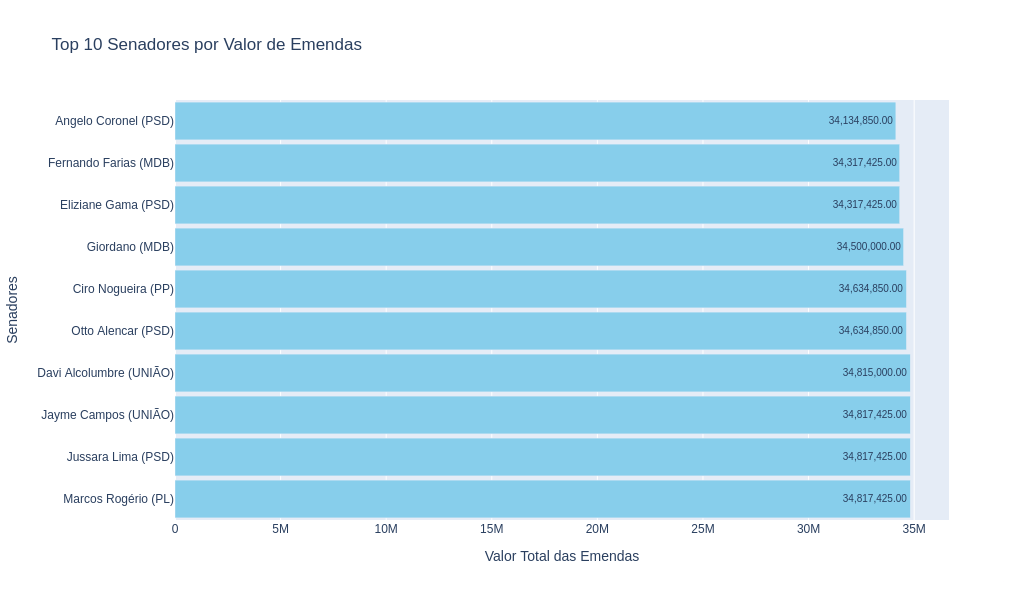

In [17]:
# Criando o gráfico de barras horizontais
fig = go.Figure(go.Bar(
    x=df_emendas_senadores.values,
    y=df_emendas_senadores.index.map(lambda x: f"{x[0]} ({x[1]}/{x[2]})"),
    orientation='h',
    marker_color='skyblue'
))

# Adicionando título e rótulos aos eixos
fig.update_layout(
    title='Top 10 Senadores por Valor de Emendas',
    xaxis_title='Valor Total das Emendas',
    yaxis_title='Senadores',
    font_size=12
)

# Exibindo os valores nas barras
for i, value in enumerate(df_emendas_senadores.values):
    fig.add_annotation(
        x=value,
        y=i,
        text=f'{value:,.2f}',
        textangle=0,
        font_size=10,
        showarrow=False,
        align='left',
        xanchor='right'
    )

# Ajustando o layout
fig.update_layout(
    height=600,
    width=800,
    bargap=0.1
)

# Exibindo o gráfico
fig.show()